Mengimport beberapa libtrary yang diubutuhkan

In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

Memuat dataset

In [2]:
# Replace FILE_ID with the actual ID of your file from Google Drive link
books_link = "https://drive.google.com/uc?id=1_Y2UJgyHSa4cCqQHB-eg6ZVSjwl45Zbi&export=download"
ratings_link = "https://drive.google.com/uc?id=1BvjPHW5SGd_koNFh_MpUhLQC8wEqcRar&export=download"

# Load CSV files from the corrected links
books = pd.read_csv(books_link)
ratings = pd.read_csv(ratings_link)

Menampilkan Informasi Dataset Buku

In [3]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

Menampilkan Informasi Dataset ratings

In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB


Menghitung Jumlah Unik dalam Dataset

In [5]:
print('Jumlah book_id uniqe dalam books: ', len(books.book_id.unique()))
print('Jumlah best_book_id uniqe dalam books: ', len(books.best_book_id.unique()))
print('Jumlah book_id uniqe dalam ratings: ', len(ratings.book_id.unique()))
print('Jumlah user_id uniqe dalam ratings: ', len(ratings.user_id.unique()))

Jumlah book_id uniqe dalam books:  10000
Jumlah best_book_id uniqe dalam books:  10000
Jumlah book_id uniqe dalam ratings:  10000
Jumlah user_id uniqe dalam ratings:  53424


### Insight dari Jumlah Unik dalam Dataset

1. **Jumlah Unik `book_id`**: Terdapat 10.000 `book_id` yang unik dalam dataset buku dan rating. Ini menunjukkan bahwa setiap buku memiliki identifikasi yang jelas dan terpisah, yang penting untuk analisis lebih lanjut, seperti rekomendasi buku.

2. **Jumlah Unik `best_book_id`**: Semua 10.000 `best_book_id` juga unik, menandakan bahwa setiap buku dalam dataset dianggap sebagai buku terbaik, sesuai dengan kategorisasi yang ada. Hal ini dapat memberikan gambaran tentang keberagaman pilihan buku yang tersedia.

3. **Jumlah Unik `user_id`**: Dengan 53.424 `user_id` yang unik dalam dataset rating, ini menunjukkan bahwa ada banyak pengguna yang berinteraksi dengan buku-buku dalam dataset. Tingginya jumlah pengguna dapat memberikan peluang untuk analisis perilaku pembaca dan rekomendasi yang lebih personal.

4. **Kesimpulan**: Dataset ini menyediakan cakupan yang baik baik dari segi jumlah buku maupun interaksi pengguna, memungkinkan analisis yang mendalam tentang preferensi pembaca dan potensi sistem rekomendasi yang lebih efektif.


### Menampilkan Informasi Dataset Secara Terstruktur

Fungsi `display_info_with_break` digunakan untuk menampilkan informasi tentang dataset `books` dan `ratings` secara terstruktur. Dengan mencetak nama dataset dan informasi strukturnya, kita dapat lebih mudah memahami karakteristik dan isi masing-masing DataFrame. Selanjutnya, kita akan menjalankan fungsi ini untuk melihat informasi dari kedua dataset tersebut.


In [6]:
def display_info_with_break(dataset_names, *dfs):
    for name, df in zip(dataset_names, dfs):
        print(f"Ini merupakan dataset: {name}")
        df.info()
        print("\n" + "-" * 60 + "\n")

# Nama dataset yang akan digunakan
dataset_names = ["books.csv", "ratings.csv"]

# Menjalankan fungsi untuk tiap DataFrame
display_info_with_break(dataset_names, books, ratings)

Ini merupakan dataset: books.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count 

### Pemeriksaan Kualitas Dataset

Dalam bagian ini, kita mendefinisikan beberapa fungsi untuk memeriksa kualitas dataset `books` dan `ratings`:

1. **Pemeriksaan Missing Values**: Fungsi `check_missing_values` digunakan untuk mengidentifikasi jumlah nilai yang hilang dalam setiap kolom dari dataset.

2. **Pemeriksaan Duplikat**: Fungsi `check_duplicates` digunakan untuk menghitung jumlah entri duplikat dalam dataset, yang penting untuk memastikan integritas data.

3. **Tipe Data**: Fungsi `check_data_types` digunakan untuk memeriksa tipe data setiap kolom dalam dataset, membantu kita memahami format data yang tersedia.

Dengan melakukan pemeriksaan ini, kita dapat memastikan bahwa data yang akan dianalisis bersih dan dalam format yang sesuai.


In [7]:
# Menyimpan nama dataset untuk referensi
dataset_names = ["books", "ratings"]

# 1. Pemeriksaan Missing Values
def check_missing_values(dfs, names):
    for name, df in zip(names, dfs):
        print(f"\nMissing values in {name}:")
        print(df.isnull().sum())

# 2. Pemeriksaan Duplikat
def check_duplicates(dfs, names):
    for name, df in zip(names, dfs):
        print(f"\nNumber of duplicates in {name}: {df.duplicated().sum()}")

# 3. Tipe Data
def check_data_types(dfs, names):
    for name, df in zip(names, dfs):
        print(f"\nData types in {name}:")
        print(df.dtypes)

Mengecek duplikat

In [8]:
check_duplicates([books, ratings], dataset_names)


Number of duplicates in books: 0

Number of duplicates in ratings: 1644


### Hasil Pemeriksaan Duplikat

Setelah menjalankan pemeriksaan duplikat pada dataset:

- **Buku**: Tidak ada entri duplikat dalam dataset `books`, yang menunjukkan bahwa setiap buku memiliki identifikasi unik dan tidak ada pengulangan data.

- **Rating**: Terdapat 1.644 entri duplikat dalam dataset `ratings`. Hal ini mengindikasikan bahwa beberapa pengguna mungkin memberikan rating yang sama untuk buku yang sama lebih dari sekali. Kita perlu mempertimbangkan cara menangani duplikat ini, apakah akan dihapus atau dianalisis lebih lanjut, tergantung pada konteks analisis yang akan dilakukan.


karena masih penasaran aku cek lagi dengan pendekatan berbeda, yaitu berdasarkan kombinasi user_id dan book_id

In [9]:
# Memeriksa duplikat di ratings berdasarkan user_id dan book_id
def check_duplicates_in_ratings(df):
    # Menghitung duplikat berdasarkan kombinasi user_id dan book_id
    duplicate_count = df.duplicated(subset=['user_id', 'book_id']).sum()
    return duplicate_count

# Menggunakan fungsi untuk mendapatkan jumlah duplikat
ratings_duplicates = check_duplicates_in_ratings(ratings)
print(f"\nNumber of duplicates in ratings based on user_id and book_id: {ratings_duplicates}")



Number of duplicates in ratings based on user_id and book_id: 2278


### Hasil Pemeriksaan Duplikat dengan Pendekatan Berbeda

Setelah memeriksa duplikat dalam dataset `ratings` berdasarkan kombinasi `user_id` dan `book_id`, ditemukan:

- **Jumlah Duplikat**: Terdapat 2.278 entri duplikat. Ini berarti ada beberapa pengguna yang memberikan rating yang sama untuk buku yang sama lebih dari sekali.

Hal ini menyoroti pentingnya memperhatikan konteks ketika menganalisis data rating, karena duplikat dapat mempengaruhi hasil analisis dan rekomendasi. Kita perlu mempertimbangkan cara yang tepat untuk menangani duplikat ini dalam analisis lebih lanjut, baik dengan menghapusnya atau menggunakan pendekatan agregasi untuk mendapatkan informasi yang lebih relevan.


Sekarang kita akan Menghapus duplikasi dan mempertahankan rating yang kedua

In [10]:
ratings_cleaned = ratings.drop_duplicates(subset=['user_id', 'book_id'], keep='last')

In [11]:
check_duplicates([books, ratings_cleaned], dataset_names)


Number of duplicates in books: 0

Number of duplicates in ratings: 0


### Hasil Pemeriksaan Duplikat Setelah Pembersihan

Setelah melakukan pembersihan pada dataset `ratings` dengan menghapus duplikasi, hasil pemeriksaan duplikat menunjukkan:

- **Buku**: Masih tidak ada entri duplikat dalam dataset `books`, yang menegaskan bahwa setiap buku memiliki identifikasi unik.

- **Rating**: Sekarang tidak ada entri duplikat dalam dataset `ratings_cleaned`. Hal ini menunjukkan bahwa semua kombinasi `user_id` dan `book_id` telah dihapus dari duplikasi, sehingga data rating kini lebih bersih dan siap untuk analisis lebih lanjut.

Dengan tidak adanya duplikat, kita dapat melakukan analisis yang lebih akurat dan efektif terhadap data rating dan rekomendasi buku.


Tahap selanjutnya kita akan mengecek missing value

In [12]:
check_missing_values([books, ratings_cleaned], dataset_names)


Missing values in books:
id                              0
book_id                         0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64

Missing values in ratings:
book_id    0
user_id    0
rating     0
dtype: int64


### Hasil Pemeriksaan Missing Values

Setelah melakukan pemeriksaan nilai yang hilang dalam dataset:

- **Books**: Dataset `books` memiliki beberapa kolom dengan nilai yang hilang:
  - **isbn**: 700 entri hilang
  - **isbn13**: 585 entri hilang
  - **original_publication_year**: 21 entri hilang
  - **original_title**: 585 entri hilang
  - **language_code**: 1084 entri hilang

  Ini menunjukkan bahwa ada data yang tidak lengkap pada kolom-kolom ini, yang dapat mempengaruhi analisis dan rekomendasi.

- **Ratings**: Dataset `ratings_cleaned` tidak memiliki nilai yang hilang. Semua kolom (`book_id`, `user_id`, dan `rating`) terisi lengkap, yang menunjukkan bahwa data rating sudah bersih dan siap untuk analisis lebih lanjut.

Mengingat adanya nilai yang hilang dalam dataset `books`, kita perlu mempertimbangkan strategi untuk menangani data hilang ini, apakah dengan penghapusan, imputasi, atau metode lain agar analisis tetap valid.


### Penanganan Missing Values dalam Dataset Books

In [13]:
# Menghapus kolom yang dianggap tidak penting
books.drop(columns=['isbn', 'isbn13', 'original_title'], inplace=True)

# Mengisi missing values untuk 'original_publication_year' dengan median
books['original_publication_year'].fillna(books['original_publication_year'].median(), inplace=True)

# Mengisi missing values untuk 'language_code' dengan mode
books['language_code'].fillna(books['language_code'].mode()[0], inplace=True)

print("Missing values telah ditangani.")

Missing values telah ditangani.


<ipython-input-13-e2bd8770a609>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  books['original_publication_year'].fillna(books['original_publication_year'].median(), inplace=True)
<ipython-input-13-e2bd8770a609>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

Dalam langkah ini, kita melakukan beberapa tindakan untuk menangani nilai yang hilang dalam dataset `books`:

1. **Penghapusan Kolom**:
   - Kolom yang dianggap tidak penting, yaitu `isbn`, `isbn13`, dan `original_title`, telah dihapus dari dataset. Penghapusan kolom ini bertujuan untuk menyederhanakan analisis dan mengurangi kompleksitas data.

2. **Imputasi Nilai Hilang**:
   - **`original_publication_year`**: Nilai yang hilang diisi dengan median dari kolom ini. Menggunakan median adalah pilihan yang baik untuk menghindari pengaruh dari outlier.
   - **`language_code`**: Nilai yang hilang diisi dengan mode (nilai yang paling sering muncul) dari kolom ini. Ini membantu memastikan bahwa data tetap representatif berdasarkan nilai yang umum.

Dengan langkah-langkah ini, kita telah menangani nilai yang hilang dalam dataset `books`, sehingga data siap untuk analisis lebih lanjut.

**Status**: "Missing values telah ditangani."

Kita mengecek lagi apakah missing value berhasil di tangani

In [14]:
check_missing_values([books, ratings_cleaned], dataset_names)


Missing values in books:
id                           0
book_id                      0
best_book_id                 0
work_id                      0
books_count                  0
authors                      0
original_publication_year    0
title                        0
language_code                0
average_rating               0
ratings_count                0
work_ratings_count           0
work_text_reviews_count      0
ratings_1                    0
ratings_2                    0
ratings_3                    0
ratings_4                    0
ratings_5                    0
image_url                    0
small_image_url              0
dtype: int64

Missing values in ratings:
book_id    0
user_id    0
rating     0
dtype: int64


### Hasil Pemeriksaan Missing Values Setelah Penanganan

Setelah melakukan penanganan nilai yang hilang dalam dataset `books`, kita melakukan pemeriksaan ulang terhadap nilai yang hilang:

- **Books**: Setelah penanganan, tidak ada lagi nilai yang hilang dalam dataset `books`. Semua kolom kini terisi lengkap, termasuk kolom yang sebelumnya memiliki nilai yang hilang:
  - **`original_publication_year`**: Kini sudah terisi dengan median.
  - **`language_code`**: Sudah terisi dengan mode.

- **Ratings**: Dataset `ratings_cleaned` juga tidak memiliki nilai yang hilang. Semua kolom (`book_id`, `user_id`, dan `rating`) terisi lengkap.

Dengan demikian, langkah-langkah yang diambil untuk menangani nilai yang hilang berhasil, dan kedua dataset kini siap untuk analisis lebih lanjut.


### Pemilihan Kolom Penting dari Dataset Books

Dalam langkah ini, kita melakukan pemilihan kolom-kolom penting dari dataset `books` untuk digunakan dalam analisis selanjutnya.

In [15]:
# Menentukan kolom yang ingin disimpan dari books
columns_to_keep = ['book_id', 'authors', 'original_publication_year', 'title', 'language_code', 'average_rating']

# Mengambil kolom yang diinginkan dari books
cleaned_books = books[columns_to_keep]

Dengan hanya menyimpan kolom-kolom yang relevan, dataset `cleaned_books` menjadi lebih fokus dan lebih mudah untuk dianalisis tanpa menyertakan data yang tidak diperlukan.

### Penggabungan Dataset Ratings dan Books

Pada langkah ini, kita menggabungkan dataset `ratings_cleaned` dengan dataset `cleaned_books` berdasarkan kolom `book_id`. Penggabungan ini dilakukan dengan menggunakan metode **left join**, yang memastikan semua entri dari `ratings_cleaned` disertakan, sementara hanya kolom yang cocok dari `cleaned_books` yang ditambahkan.

In [16]:
# Menggabungkan ratings_cleaned dengan cleaned_books
merged_df = pd.merge(ratings_cleaned, cleaned_books, on='book_id', how='left')

Hasil dari penggabungan ini adalah `merged_df`, yang kini berisi informasi tentang rating buku serta atribut penting dari buku seperti penulis, tahun publikasi, judul, kode bahasa, dan rata-rata rating. Dengan cara ini, kita dapat melakukan analisis lebih lanjut yang mengaitkan data rating dengan informasi buku.


### Memeriksa Nilai NaN Setelah Penggabungan

Setelah menggabungkan dataset `ratings_cleaned` dengan `cleaned_books`, langkah selanjutnya adalah memeriksa apakah terdapat nilai NaN (missing values) dalam dataset gabungan `merged_df`. Hal ini penting untuk memastikan bahwa tidak ada informasi penting yang hilang setelah proses penggabungan.

Dengan memeriksa nilai NaN, kita dapat mengidentifikasi kolom mana yang mungkin masih memiliki data yang hilang, sehingga langkah penanganan missing values dapat dilakukan jika diperlukan. Proses ini penting untuk menjaga kualitas dan integritas data sebelum melanjutkan analisis lebih lanjut.


In [17]:
merged_df

,book_id,user_id,rating,authors,original_publication_year,title,language_code,average_rating
0,1,314,5,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54
1,1,439,3,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54
2,1,588,5,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54
3,1,1169,4,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54
4,1,1185,4,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54
...,...,...,...,...,...,...,...,...
979473,10000,48386,5,NaN,NaN,NaN,NaN,NaN
979474,10000,49007,4,NaN,NaN,NaN,NaN,NaN
979475,10000,49383,5,NaN,NaN,NaN,NaN,NaN
979476,10000,50124,5,NaN,NaN,NaN,NaN,NaN


### Mencari book_id yang Hilang

Pada langkah ini, kita mencari `book_id` yang terdapat dalam dataset `ratings_cleaned` namun tidak ada dalam dataset `cleaned_books`. Hal ini dilakukan dengan menggunakan operasi set untuk membandingkan kedua kolom `book_id`.

Hasil dari operasi ini akan memberikan kita jumlah `book_id` yang hilang. Informasi ini penting untuk memahami apakah ada rating yang mengacu pada buku yang tidak terdaftar dalam dataset buku, yang dapat mempengaruhi analisis lebih lanjut. Jika jumlah `book_id` yang hilang signifikan, kita mungkin perlu mempertimbangkan langkah-langkah tambahan untuk menangani data tersebut.


In [18]:
# Menemukan book_id yang ada di ratings_cleaned tapi tidak ada di cleaned_books
missing_books = set(ratings_cleaned['book_id']) - set(cleaned_books['book_id'])

print("Jumlah book_id yang hilang:", len(missing_books))


Jumlah book_id yang hilang: 9188


Hasil dari analisis ini menunjukkan bahwa terdapat **9188 `book_id` yang hilang** dari dataset buku. Ini menandakan bahwa meskipun kita memiliki banyak data rating, banyak di antaranya tidak terhubung dengan informasi buku yang relevan. Mengetahui jumlah `book_id` yang hilang penting untuk memahami cakupan data yang kita miliki dan dapat mempengaruhi analisis serta rekomendasi yang akan dilakukan.

### Memeriksa Jumlah Baris dan Beberapa book_id dari Dataset Buku

Dalam langkah ini, kita memeriksa jumlah total baris dalam dataset `books`, yang menunjukkan bahwa terdapat **10.000 entri buku**. Ini memberi kita gambaran tentang ukuran dataset dan jumlah buku yang tersedia untuk analisis.

In [19]:
print("Jumlah baris dalam books:", books.shape[0])
print("Beberapa book_id dari books:", books['book_id'].unique()[:10])


Jumlah baris dalam books: 10000
Beberapa book_id dari books: [ 2767052        3    41865     2657     4671 11870085     5907     5107
      960     1885]



Selain itu, kita juga menampilkan beberapa `book_id` unik dari dataset ini. Dari hasil yang ditampilkan, kita dapat melihat contoh `book_id` seperti 2767052, 3, 41865, dan seterusnya. Informasi ini berguna untuk memahami struktur data dan membantu dalam analisis lebih lanjut.

### Memeriksa Duplikat dan Jumlah Unik book_id

Pada langkah ini, kita melakukan pemeriksaan terhadap kolom `book_id` dalam dataset `books` untuk memastikan bahwa tidak ada duplikat. Hasil menunjukkan bahwa **tidak ada duplikat book_id** dalam dataset, yang berarti setiap buku memiliki identifikasi yang unik.

Selanjutnya, kita juga menghitung jumlah `book_id` unik, yang menunjukkan bahwa ada **10.000 unique book_id** di dalam dataset. Informasi ini penting untuk memastikan integritas data dan mencegah adanya kesalahan dalam analisis yang dapat disebabkan oleh duplikasi.


In [20]:
print("Duplikat book_id di books:", books['book_id'].duplicated().sum())
print("Jumlah unique book_id di books:", books['book_id'].nunique())

Duplikat book_id di books: 0
Jumlah unique book_id di books: 10000


### Menampilkan Contoh book_id yang Hilang

Setelah kita menemukan bahwa ada **9188 book_id yang hilang** dari dataset `cleaned_books`, kita membuat daftar dari `book_id` yang hilang dan menampilkan beberapa contoh. Hasil menunjukkan contoh book_id yang hilang sebagai berikut:



In [21]:
missing_books_list = list(missing_books)
print("Contoh book_id yang hilang:", missing_books_list[:10])


Contoh book_id yang hilang: [4, 7, 9, 12, 14, 15, 16, 17, 18, 19]


- **Contoh book_id yang hilang:** `[4, 7, 9, 12, 14, 15, 16, 17, 18, 19]`

Informasi ini membantu kita untuk memahami buku-buku yang terdapat dalam dataset `ratings_cleaned` tetapi tidak ada dalam dataset `cleaned_books`. Hal ini bisa menjadi perhatian lebih lanjut untuk menginvestigasi mengapa buku-buku ini tidak terdaftar dan apakah itu mempengaruhi analisis yang akan dilakukan.

### Menampilkan Contoh book_id dari ratings_cleaned

Kita juga ingin melihat contoh `book_id` yang terdapat dalam dataset `ratings_cleaned`. Berikut adalah contoh yang diperoleh:

In [22]:
print("Contoh book_id dari ratings_cleaned:", ratings_cleaned['book_id'].unique()[:10])

Contoh book_id dari ratings_cleaned: [ 1  2  3  4  5  6  7  8  9 10]


- **Contoh book_id dari ratings_cleaned:** `[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]`

Ini menunjukkan bahwa dataset `ratings_cleaned` memiliki `book_id` yang bervariasi mulai dari 1 hingga 10. Mengetahui book_id ini penting untuk memahami buku mana yang paling sering dinilai dan apakah ada kecocokan dengan dataset `cleaned_books`.


### Menyaring ratings_cleaned untuk book_id yang Tersedia di cleaned_books

Kita menyaring dataset `ratings_cleaned` untuk hanya mengambil baris yang memiliki `book_id` yang ada di `cleaned_books`. Ini dilakukan dengan menggunakan fungsi `.isin()` untuk memastikan kita hanya mempertahankan data yang relevan:

In [23]:
# Hanya ambil yang ada di cleaned_books
ratings_cleaned_filtered = ratings_cleaned[ratings_cleaned['book_id'].isin(cleaned_books['book_id'])]

Menggabungkan DataFrame yang Telah Difilter

In [24]:
# Menggabungkan setelah filtering
merged_df = pd.merge(ratings_cleaned_filtered, cleaned_books, on='book_id', how='left')

In [25]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79531 entries, 0 to 79530
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    79531 non-null  int64  
 1   user_id                    79531 non-null  int64  
 2   rating                     79531 non-null  int64  
 3   authors                    79531 non-null  object 
 4   original_publication_year  79531 non-null  float64
 5   title                      79531 non-null  object 
 6   language_code              79531 non-null  object 
 7   average_rating             79531 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 4.9+ MB


dari output yang Anda tunjukkan untuk merged_df.info(), dapat diketahui bahwa tidak ada nilai NaN (null) di setiap kolom. Hal ini terlihat dari kolom Non-Null Count yang menunjukkan bahwa semua kolom memiliki 79,531 entri non-null. Dengan kata lain, semua kolom dalam DataFrame ini memiliki nilai yang valid dan tidak ada yang kosong.

In [26]:
merged_df

,book_id,user_id,rating,authors,original_publication_year,title,language_code,average_rating
0,1,314,5,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54
1,1,439,3,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54
2,1,588,5,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54
3,1,1169,4,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54
4,1,1185,4,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54
...,...,...,...,...,...,...,...,...
79526,9998,51295,5,"Kōbō Abe, E. Dale Saunders",1962.0,The Woman in the Dunes,eng,3.91
79527,9998,51559,5,"Kōbō Abe, E. Dale Saunders",1962.0,The Woman in the Dunes,eng,3.91
79528,9998,52087,4,"Kōbō Abe, E. Dale Saunders",1962.0,The Woman in the Dunes,eng,3.91
79529,9998,52330,4,"Kōbō Abe, E. Dale Saunders",1962.0,The Woman in the Dunes,eng,3.91


Memeriksa apakah ada nilai NaN di merged_df

In [27]:
nan_check = merged_df.isna().sum()
nan_check[nan_check > 0]  # Menampilkan hanya kolom yang memiliki NaN

,0


Untuk meringankan tingkat komputasi saat menghitung **cosine similarity** pada tahap kedepannya,pentingnya langkah-langkah berikut diambil:

In [28]:
# Fungsi untuk membersihkan teks menjadi huruf ASCII saja
def clean_text(text):
    # Mengubah menjadi huruf kecil dan hanya mempertahankan huruf, angka, dan spasi
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)  # Hapus karakter selain huruf, angka, dan spasi
    return text.lower()

# Terapkan fungsi ke kolom 'title' dan 'authors'
merged_df['title'] = merged_df['title'].apply(clean_text)
merged_df['authors'] = merged_df['authors'].apply(clean_text)

# Cek data setelah pembersihan
print(merged_df[['title', 'authors']].head())


                                               title                  authors
0  harry potter and the halfblood prince harry po...  jk rowling mary grandpr
1  harry potter and the halfblood prince harry po...  jk rowling mary grandpr
2  harry potter and the halfblood prince harry po...  jk rowling mary grandpr
3  harry potter and the halfblood prince harry po...  jk rowling mary grandpr
4  harry potter and the halfblood prince harry po...  jk rowling mary grandpr


1. **Pembersihan Teks**: Karakter non-alfabetik dan non-numerik dihapus dari kolom **`title`** dan **`authors`**. Hal ini membantu memastikan bahwa hanya informasi yang relevan yang dipertahankan.
   
2. **Normalisasi**: Mengubah semua teks menjadi huruf kecil untuk konsistensi. Ini menghindari perbedaan yang tidak perlu antara huruf besar dan kecil, yang dapat mempengaruhi hasil perhitungan.

3. **Pengurangan Dimensi**: Dengan membersihkan data, ukuran dataset berkurang, sehingga mengurangi kompleksitas dan waktu yang dibutuhkan untuk menghitung cosine similarity.

Langkah-langkah ini berkontribusi pada efisiensi perhitungan dan meningkatkan keakuratan dalam analisis data.

Setelah pembersihan teks, langkah selanjutnya adalah memverifikasi apakah ada nilai **NaN** di kolom **`title`** dan **`authors`**.


In [29]:
# Cek jumlah nilai NaN di kolom 'title' dan 'authors'
nan_values = merged_df[['title', 'authors']].isnull().sum()

# Tampilkan hasilnya
print(nan_values)

title      0
authors    0
dtype: int64


Hasil pemeriksaan menunjukkan bahwa jumlah nilai **NaN** di kedua kolom adalah 0. Ini menandakan bahwa proses pembersihan telah berhasil dan semua data dalam kolom tersebut lengkap, yang penting untuk langkah-langkah analisis selanjutnya.

mendapatkan gambaran umum tentang DataFrame **`merged_df`**.

In [30]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79531 entries, 0 to 79530
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    79531 non-null  int64  
 1   user_id                    79531 non-null  int64  
 2   rating                     79531 non-null  int64  
 3   authors                    79531 non-null  object 
 4   original_publication_year  79531 non-null  float64
 5   title                      79531 non-null  object 
 6   language_code              79531 non-null  object 
 7   average_rating             79531 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 4.9+ MB


Dataset sudah bersih sekarang mari kita lihat insight data yang sudah di olah

Visualisasi ini menunjukkan distribusi rating rata-rata buku menggunakan histogram.

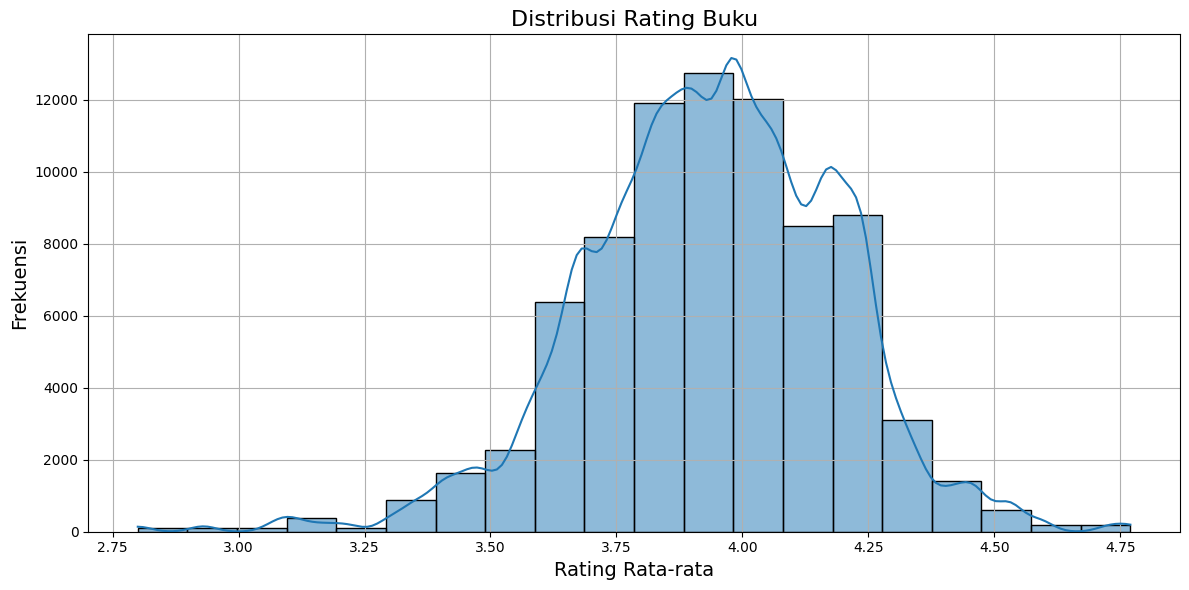

In [31]:
plt.figure(figsize=(12, 6))
sns.histplot(merged_df['average_rating'], bins=20, kde=True)
plt.title('Distribusi Rating Buku', fontsize=16)
plt.xlabel('Rating Rata-rata', fontsize=14)
plt.ylabel('Frekuensi', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

Grafik diatas menunjukkan distribusi yang menyerupai distribusi normal dengan puncak di sekitar rating 4. Ini menunjukkan bahwa sebagian besar buku mendapatkan rating yang baik, di atas rata-rata.

Visualisasi ini menunjukkan bagaimana rating buku bervariasi berdasarkan penulis terpopuler.

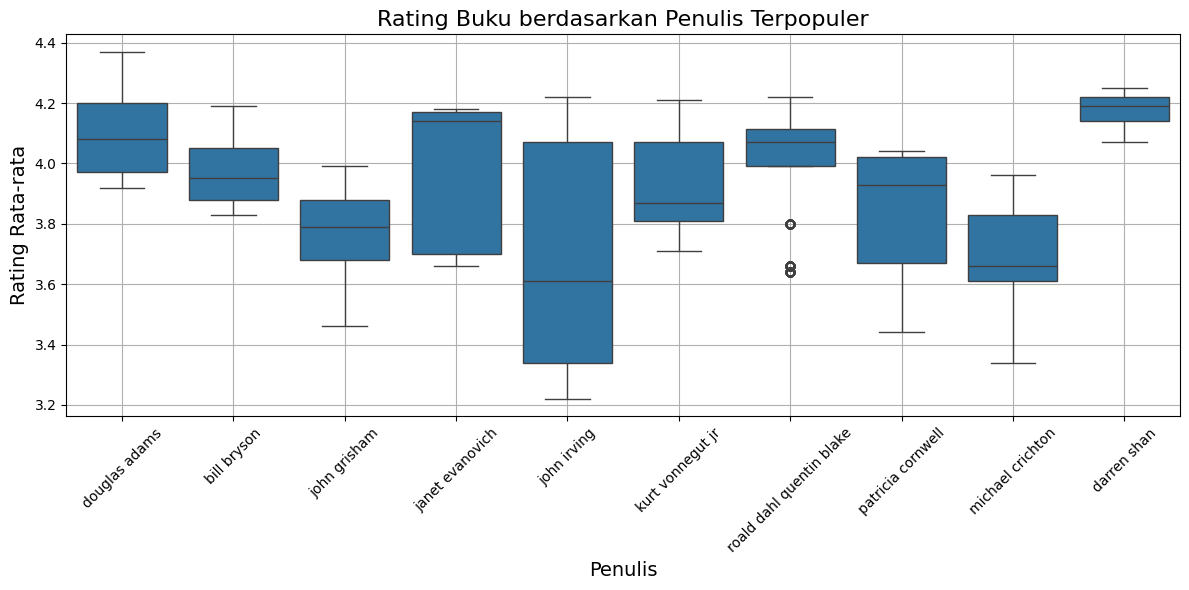

In [32]:
top_authors = merged_df['authors'].value_counts().nlargest(10).index
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df[merged_df['authors'].isin(top_authors)], x='authors', y='average_rating')
plt.title('Rating Buku berdasarkan Penulis Terpopuler', fontsize=16)
plt.xlabel('Penulis', fontsize=14)
plt.ylabel('Rating Rata-rata', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Variasi Rating yang Signifikan: Meskipun semua penulis tergolong populer, terdapat variasi yang cukup signifikan dalam rata-rata rating buku mereka. Ini menunjukkan bahwa popularitas seorang penulis tidak selalu berkorelasi langsung dengan kualitas buku yang dianggap oleh pembaca.

Membuat fitur gabungan dari 'authors' dan 'title'

In [33]:
merged_df['features'] = merged_df['authors'] + ' ' + merged_df['title']

# Mengambil 1.100 entri acak
Dengan mengurangi ukuran dataset dari 79.531 entri menjadi 1.100, kita dapat mengatasi masalah performa dan waktu komputasi yang tinggi. Alasan lainnya adalah runtime terputus saat menjalankan analisis pada dataset yang lebih besar (seperti 10.000 dan 5.000 entri). Pengambilan sampel ini memungkinkan eksekusi analisis atau model dengan lebih cepat dan efisien. Parameter `random_state` digunakan untuk memastikan hasil pengambilan sampel dapat direproduksi di masa mendatang, sehingga menjaga konsistensi dalam eksperimen.


In [34]:
# Mengambil 1.100 entri acak
merged_df = merged_df.sample(n=1100, random_state=42)  # random_state untuk reproducibility

# Inisialisasi TfidfVectorizer
Langkah ini dilakukan untuk mempersiapkan representasi fitur teks menggunakan **TF-IDF (Term Frequency-Inverse Document Frequency)**, yang berguna dalam menganalisis teks. Dengan menginisialisasi `TfidfVectorizer`, kita dapat menghitung bobot pentingnya kata-kata dalam kolom `features`, yang merupakan gabungan dari judul buku dan penulis.

# Melakukan perhitungan idf pada data cuisine
Setelah inisialisasi, kita melakukan perhitungan IDF (Inverse Document Frequency) pada data fitur. Ini membantu mengukur seberapa umum atau langka kata dalam keseluruhan dataset, sehingga dapat menyesuaikan bobot kata berdasarkan frekuensinya.

# Mapping array dari fitur index integer ke fitur nama
Dengan menggunakan `tf.get_feature_names_out()`, kita dapat memperoleh nama-nama fitur yang sesuai dengan indeks integer yang dihasilkan oleh TF-IDF. Ini sangat berguna untuk memahami fitur yang digunakan dalam model dan analisis selanjutnya.


In [35]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf pada data
tf.fit(merged_df['features'])

# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['01', '10', '11', ..., 'zodiac', 'zoltan', 'zooey'], dtype=object)

# Melakukan fit lalu ditransformasikan ke bentuk matrix
Pada langkah ini, kita menerapkan metode `fit_transform()` pada `TfidfVectorizer` untuk menghitung dan mengonversi teks dalam kolom `features` menjadi representasi matriks TF-IDF. Matriks ini akan memiliki dimensi yang merepresentasikan jumlah entri dan jumlah fitur unik yang dihasilkan dari teks.

# Melihat ukuran matrix tfidf
Dengan memanggil `tfidf_matrix.shape`, kita dapat melihat ukuran matriks TF-IDF. Ukuran ini memberikan informasi tentang jumlah entri (baris) dan jumlah fitur unik (kolom) yang terlibat, yang penting untuk memahami kompleksitas data sebelum melanjutkan ke langkah analisis berikutnya.


In [36]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(merged_df['features'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(1100, 2148)

# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
Di sini, kita menggunakan fungsi `todense()` untuk mengonversi matriks sparse TF-IDF menjadi matriks dense. Ini memungkinkan kita untuk melihat representasi penuh dari nilai-nilai TF-IDF untuk setiap fitur dalam data kita. Konversi ini berguna untuk analisis dan visualisasi lebih lanjut, meskipun harus diperhatikan bahwa matriks dense dapat memakan lebih banyak memori, terutama jika ukuran data sangat besar.


In [37]:
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

# Membuat DataFrame dari matriks TF-IDF
Dengan kode ini, kita mengonversi matriks TF-IDF yang telah diubah menjadi bentuk dense ke dalam DataFrame pandas. Setiap kolom pada DataFrame ini merepresentasikan fitur (kata) yang diekstrak menggunakan `TfidfVectorizer`, sementara indeksnya diatur berdasarkan judul buku dari DataFrame `merged_df`.

Kemudian, kita menampilkan sampel acak dari 22 kolom dan 10 baris untuk memberikan gambaran tentang nilai-nilai TF-IDF yang telah dihitung. Ini membantu kita memahami sebaran nilai TF-IDF di antara berbagai fitur dan buku yang ada dalam dataset.


In [38]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=merged_df.title
).sample(22, axis=1).sample(10, axis=0)

,bullshit,valkyries,gonzlez,it,thomson,oresteia,chalk,decides,rachael,dc,...,unfinished,hope,peters,zafn,mixedup,rats,known,bloomquist,stanley,don
title,,,,,,,,,,,,,,,,,,,,,
the johnstown flood,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000
don quixote,0.0,0.0,0.326007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.270143
icy sparks,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000
the kalahari typing school for men no 1 ladies detective agency 4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000
disgrace,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000
the poisonwood bible,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000
mrs frisby and the rats of nimh rats of nimh 1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.57737,0.0,0.0,0.0,0.000000
mother of pearl,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000
waiting for the barbarians,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000


# Menghitung Cosine Similarity pada Matriks TF-IDF
Dengan menggunakan fungsi `cosine_similarity`, kita menghitung nilai cosine similarity antara semua entri dalam matriks TF-IDF. Nilai cosine similarity ini memberikan indikasi sejauh mana dua entri (dalam hal ini, buku) mirip satu sama lain berdasarkan fitur yang telah digabungkan (judul dan penulis).

Hasil dari perhitungan ini adalah matriks dua dimensi, di mana setiap elemen (i, j) menunjukkan tingkat kesamaan antara entri ke-i dan ke-j. Nilai berkisar antara 0 (tidak ada kesamaan) hingga 1 (identik). Matriks ini akan digunakan untuk memberikan rekomendasi buku yang mirip di tahap selanjutnya.


In [39]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.02119889, 0.        , ..., 0.0217507 , 0.00862689,
        0.        ],
       [0.02119889, 1.        , 0.        , ..., 0.02085971, 0.0082735 ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.06413871],
       ...,
       [0.0217507 , 0.02085971, 0.        , ..., 1.        , 0.00848886,
        0.        ],
       [0.00862689, 0.0082735 , 0.        , ..., 0.00848886, 1.        ,
        0.        ],
       [0.        , 0.        , 0.06413871, ..., 0.        , 0.        ,
        1.        ]])

# Membuat DataFrame dari Matriks Cosine Similarity
Setelah menghitung cosine similarity, kita membuat DataFrame baru bernama `cosine_sim_df` dari variabel `cosine_sim`. DataFrame ini memiliki baris dan kolom yang diindeks berdasarkan judul buku, sehingga memudahkan dalam melihat kesamaan antar buku.

Matriks ini memiliki bentuk (shape) yang menunjukkan jumlah buku yang ada dalam dataset. Selanjutnya, kita dapat menampilkan beberapa contoh nilai similarity untuk mendapatkan gambaran bagaimana buku-buku tersebut saling terkait.


In [40]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama resto
cosine_sim_df = pd.DataFrame(cosine_sim, index=merged_df['title'], columns=merged_df['title'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap resto
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (1100, 1100)


title,my name is red,the iliad,carter beats the devil,so long and thanks for all the fish hitchhikers guide to the galaxy 4,the bone collector lincoln rhyme 1
title,,,,,
complications a surgeons notes on an imperfect science,0.000000,0.000000,0.000000,0.000000,0.000000
red prophet tales of alvin maker 2,0.107329,0.000000,0.000000,0.000000,0.000000
founding brothers the revolutionary generation,0.000000,0.010317,0.012858,0.019101,0.010483
jailbird,0.000000,0.000000,0.000000,0.000000,0.000000
a million little pieces,0.000000,0.000000,0.000000,0.000000,0.000000
the tipping point how little things can make a big difference,0.000000,0.008635,0.010762,0.015987,0.008774
the restaurant at the end of the universe hitchhikers guide 2,0.000000,0.030038,0.037436,0.373914,0.030522
the book of ruth,0.000000,0.014362,0.017899,0.026590,0.014594
a midsummer nights dream,0.000000,0.000000,0.000000,0.000000,0.000000


Nilai antara 0 dan 1 menunjukkan tingkat kesamaan, di mana semakin mendekati 1, semakin mirip buku-buku tersebut.

## Fungsi `buku_recommendations`

Fungsi ini digunakan untuk memberikan rekomendasi buku berdasarkan kesamaan (similarity) dengan buku yang diberikan.


In [41]:
def buku_recommendations(nama_buku, similarity_data=cosine_sim_df, items=merged_df[['title', 'authors', 'average_rating']], k=5):

    # Mendapatkan indeks dari buku yang mirip dengan menggunakan argpartition
    index = similarity_data.loc[:, nama_buku].to_numpy().argpartition(range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari indeks yang ada
    closest = similarity_data.columns[index[-1:-(k+1):-1].flatten()]  # Ambil k terbesar

    # Menghapus buku yang direkomendasikan untuk diri sendiri
    closest = closest[closest != nama_buku]  # Menghapus nama buku yang sama

    # Menghapus duplikat dan mengonversi kembali ke DataFrame
    closest_unique = pd.Series(closest).drop_duplicates().values  # Ambil yang unik

    # Menggabungkan dengan data buku yang relevan seperti judul, penulis, dan peringkat
    recommendations = pd.DataFrame(closest_unique, columns=['title']).merge(items, on='title', how='left')

    # Menghapus duplikat setelah penggabungan dan memilih k teratas
    recommendations = recommendations.drop_duplicates().head(k)

    return recommendations

## Menampilkan Daftar Buku

Dalam kode ini, kita mengambil 10 nama buku dari DataFrame `merged_df` yang sebelumnya telah disampling menjadi 1.100 entri secara acak. Langkah ini penting untuk memastikan bahwa kita mengetahui buku-buku yang tersedia dalam dataset sebelum melakukan rekomendasi. Dengan menampilkan hanya 10 buku, kita dapat dengan mudah mengecek beberapa entri tanpa harus melihat keseluruhan dataset.

In [60]:
# # Mengambil 10 nama buku, penulis, dan rating dari merged_df
daftar_buku = merged_df[['title', 'authors', 'average_rating']].head(10)

# # Menampilkan daftar buku
print(daftar_buku)

                                                   title  \
62596  awakening the buddha within tibetan wisdom for...   
67041                            the bellmaker redwall 7   
19057                                     my name is red   
1447                           notes from a small island   
74148                      shopaholic  baby shopaholic 5   
65922    the cat in the hat and other dr seuss favorites   
9002                               the egypt game game 1   
24076                               going after cacciato   
62043     founding brothers the revolutionary generation   
6578                                             no logo   

                        authors  average_rating  
62596            lama surya das            4.18  
67041             brian jacques            3.95  
19057  orhan pamuk erda m gknar            3.83  
1447                bill bryson            3.91  
74148           sophie kinsella            3.77  
65922          dr seuss various        

## Rekomendasi Buku

Setelah menjalankan fungsi `buku_recommendations` dengan input `'the bellmaker redwall 7'`, kita mendapatkan rekomendasi buku berdasarkan kemiripan konten. Hasil yang ditampilkan mencakup:
1. **Judul Buku**: Buku yang direkomendasikan berdasarkan kemiripan.
2. **Penulis**: Nama penulis dari buku tersebut.
3. **Rata-rata Rating**: Rating rata-rata dari pembaca untuk memberikan gambaran tentang kualitas buku.


In [43]:
print(buku_recommendations('the bellmaker redwall 7'))

                          title        authors  average_rating
0             redwall redwall 1  brian jacques            4.11
1  outcast of redwall redwall 8  brian jacques            3.90


Sebagai contoh, dua buku yang direkomendasikan adalah:

- **"redwall redwall 1"** oleh **Brian Jacques** dengan rating **4.11**.
- **"outcast of redwall redwall 8"** oleh **Brian Jacques** dengan rating **3.90**.

Rekomendasi ini bertujuan untuk membantu pembaca menemukan buku-buku lain yang mungkin menarik berdasarkan kesamaan tema atau konten dengan buku yang telah mereka pilih.

Sekarang kita akan membahas Collaborative Filtering

In [45]:
# Mengganti nama DataFrame
book_data = merged_df

In [46]:
# Membuat matriks pengguna-buku
user_book_matrix = book_data.pivot_table(index='user_id', columns='book_id', values='rating').fillna(0)

kita akan menggunakan pendekatan NN

In [47]:
# Membuat model NN
model_nn = NearestNeighbors(metric='cosine', algorithm='brute')
model_nn.fit(user_book_matrix.values)

NearestNeighbors(algorithm='brute', metric='cosine')

In [54]:
# Mendapatkan jarak dan indeks dari pengguna terdekat
distances, indices = model_nn.kneighbors(user_book_matrix, n_neighbors=user_book_matrix.shape[0])

menghitung dan menyimpan kemiripan antara pengguna berdasarkan interaksi mereka dengan buku

In [55]:
user_similarity_df = pd.DataFrame(1 - distances, index=user_book_matrix.index, columns=user_book_matrix.index)

In [48]:
def top_n_recommendations(user_id, user_book_matrix, user_similarity_df, merged_df, top_n=5):
    # Mendapatkan rating pengguna
    user_ratings = user_book_matrix.loc[user_id]

    # Mendapatkan kesamaan pengguna
    similar_users = user_similarity_df[user_id]

    # Menghitung weighted scores
    weighted_scores = user_book_matrix.T.dot(similar_users)

    # Menghapus buku yang sudah di-rating oleh pengguna
    weighted_scores = weighted_scores[~user_ratings.index.isin(user_ratings[user_ratings > 0].index)]

    # Mendapatkan top-N rekomendasi
    recommended_books = weighted_scores.nlargest(top_n)

    # Mengambil informasi buku yang direkomendasikan
    recommended_books_info = merged_df[merged_df['book_id'].isin(recommended_books.index)][['book_id', 'title', 'authors']]

    # Menghapus duplikasi jika ada
    recommended_books_info = recommended_books_info.drop_duplicates(subset='book_id')

    return recommended_books_info

In [51]:
print("Available User IDs:", user_book_matrix.index.tolist())

Available User IDs: [19, 27, 230, 407, 456, 472, 475, 588, 669, 861, 892, 926, 951, 997, 1094, 1224, 1311, 1393, 1401, 1402, 1422, 1445, 1491, 1539, 1577, 1594, 1710, 1733, 1790, 1794, 1808, 1816, 1823, 1824, 1831, 1947, 2056, 2074, 2075, 2145, 2187, 2198, 2271, 2338, 2342, 2343, 2415, 2421, 2428, 2434, 2474, 2574, 2600, 2621, 2629, 2722, 2723, 2785, 2900, 2914, 2926, 2936, 2959, 3003, 3022, 3080, 3117, 3122, 3171, 3174, 3302, 3335, 3423, 3449, 3456, 3468, 3527, 3621, 3674, 3820, 3831, 3887, 3998, 4027, 4057, 4096, 4119, 4133, 4179, 4210, 4233, 4236, 4242, 4273, 4382, 4440, 4480, 4490, 4514, 4706, 4759, 4769, 4774, 4795, 4816, 4822, 4953, 4980, 4994, 5033, 5050, 5109, 5203, 5245, 5273, 5274, 5400, 5441, 5490, 5551, 5621, 5636, 5645, 5732, 5854, 5874, 5904, 6017, 6042, 6094, 6143, 6171, 6190, 6198, 6311, 6337, 6442, 6500, 6527, 6547, 6630, 6655, 6682, 6769, 6772, 6788, 6799, 6831, 6873, 6892, 6925, 6965, 6968, 7064, 7073, 7120, 7159, 7311, 7319, 7325, 7369, 7457, 7467, 7513, 7553, 7583,

rekomendasi buku pakai collaborative

In [72]:
user_id = 951  # Ganti dengan user_id yang ada dalam dataset
# Mendapatkan dan menampilkan top-N rekomendasi
recommendations = top_n_recommendations(user_id, user_book_matrix, user_similarity_df, merged_df, top_n=5)
print("Top-N Recommendations for User ID:", user_id)
print(recommendations)

Top-N Recommendations for User ID: 951
     book_id                                              title  \
313        5  harry potter and the prisoner of azkaban harry...   
39         1  harry potter and the halfblood prince harry po...   
454        6  harry potter and the goblet of fire harry pott...   
543        8    harry potter boxed set books 15 harry potter 15   
253        3  harry potter and the sorcerers stone harry pot...   

                                authors  
313  jk rowling mary grandpr rufus beck  
39              jk rowling mary grandpr  
454             jk rowling mary grandpr  
543             jk rowling mary grandpr  
253             jk rowling mary grandpr  


**Evaluasi**

Pertama-tama content based. kita harus tau buku apa saja yang ditulis oleh brian jacques

In [63]:
# Mengambil daftar actual books yang ditulis oleh Brian Jacques
actual_books_df = merged_df[merged_df['authors'].str.contains('Brian Jacques', case=False, na=False)]

# Menghapus duplikasi
actual_books_unique_df = actual_books_df.drop_duplicates(subset='title')

# Mengambil hanya kolom title untuk daftar judul buku yang unik
actual_books = actual_books_unique_df['title'].tolist()

print("Daftar Actual Books yang ditulis oleh Brian Jacques (tanpa duplikasi):")
print(actual_books)


Daftar Actual Books yang ditulis oleh Brian Jacques (tanpa duplikasi):
['the bellmaker redwall 7', 'outcast of redwall redwall 8', 'marlfox redwall 11', 'mariel of redwall redwall 4', 'redwall redwall 1', 'pearls of lutra redwall 9', 'salamandastron redwall 5']


membuat fungsi menghitung evaluasinya

In [64]:
def evaluate_content_based_recommendations(recommended_books, actual_books):
    # Mendapatkan True Positives
    true_positives = len(set(recommended_books) & set(actual_books))

    # Menghitung False Positives dan False Negatives
    false_positives = len(set(recommended_books) - set(actual_books))
    false_negatives = len(set(actual_books) - set(recommended_books))

    # Menghitung Precision, Recall, dan F1 Score
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

    return {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    }

In [65]:
# Menggunakan rekomendasi dari Content-Based
recommended_books_cb = buku_recommendations('the bellmaker redwall 7')['title'].tolist()

# Daftar actual books yang ditulis oleh Brian Jacques
actual_books = ['the bellmaker redwall 7', 'outcast of redwall redwall 8', 'marlfox redwall 11', 'mariel of redwall redwall 4', 'redwall redwall 1', 'pearls of lutra redwall 9', 'salamandastron redwall 5']

# Evaluasi
results_cb = evaluate_content_based_recommendations(recommended_books_cb, actual_books)

hasil evaluasi

In [66]:
print("Evaluasi Content-Based Filtering:")
print(results_cb)

Evaluasi Content-Based Filtering:
{'Precision': 1.0, 'Recall': 0.2857142857142857, 'F1 Score': 0.4444444444444445}


Sekarang tahap evaluasi collabrative reccomendations

In [67]:
def evaluate_collaborative_recommendations(recommended_books, actual_books):
    # Mendapatkan True Positives
    true_positives = len(set(recommended_books) & set(actual_books))

    # Menghitung False Positives dan False Negatives
    false_positives = len(set(recommended_books) - set(actual_books))
    false_negatives = len(set(actual_books) - set(recommended_books))

    # Menghitung Precision, Recall, dan F1 Score
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

    return {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    }

Kita juga perlu mengetahui buku yang ditulis oleh jk rowling

In [74]:
# Mengambil daftar buku yang ditulis oleh J.K. Rowling
actual_books_df = merged_df[merged_df['authors'].str.contains('jk rowling', case=False, na=False)]

# Mengambil daftar judul buku tanpa duplikasi
actual_books = actual_books_df['title'].unique().tolist()

# Menampilkan daftar actual books
print("Daftar Actual Books oleh J.K. Rowling:")
print(actual_books)


Daftar Actual Books oleh J.K. Rowling:
['harry potter collection harry potter 16', 'harry potter and the prisoner of azkaban harry potter 3', 'harry potter schoolbooks box set two classic books from the library of hogwarts school of witchcraft and wizardry', 'harry potter and the halfblood prince harry potter 6', 'harry potter and the goblet of fire harry potter 4', 'harry potter boxed set books 15 harry potter 15', 'harry potter and the sorcerers stone harry potter 1']


membuat listnya untuk evaluasi

In [75]:
# Daftar actual books oleh J.K. Rowling untuk evaluasi Collaborative Filtering
actual_books_collab = [
    'harry potter collection harry potter 16',
    'harry potter and the prisoner of azkaban harry potter 3',
    'harry potter schoolbooks box set two classic books from the library of hogwarts school of witchcraft and wizardry',
    'harry potter and the halfblood prince harry potter 6',
    'harry potter and the goblet of fire harry potter 4',
    'harry potter boxed set books 15 harry potter 15',
    'harry potter and the sorcerers stone harry potter 1'
]


hasil skor evaluasi collaboration filtering

In [76]:
# Mengambil daftar judul rekomendasi
recommended_titles = recommendations['title'].tolist()

# Melakukan evaluasi
evaluation_results = evaluate_collaborative_recommendations(recommended_titles, actual_books_collab)

# Menampilkan hasil evaluasi
print("Evaluasi Collaborative Filtering:")
print(f"Precision: {evaluation_results['Precision']:.2f}")
print(f"Recall: {evaluation_results['Recall']:.2f}")
print(f"F1 Score: {evaluation_results['F1 Score']:.2f}")

Evaluasi Collaborative Filtering:
Precision: 1.00
Recall: 0.71
F1 Score: 0.83
